<a href="https://colab.research.google.com/github/Stvaishu/Projectwork2/blob/main/skin_melnoma1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/drive/MyDrive/dataset1/train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,/content/drive/MyDrive/dataset1/train/benign/1...,benign
1,/content/drive/MyDrive/dataset1/train/benign/1...,benign
2,/content/drive/MyDrive/dataset1/train/benign/1...,benign
3,/content/drive/MyDrive/dataset1/train/benign/1...,benign
4,/content/drive/MyDrive/dataset1/train/benign/1...,benign
...,...,...
2632,/content/drive/MyDrive/dataset1/train/malignan...,malignant
2633,/content/drive/MyDrive/dataset1/train/malignan...,malignant
2634,/content/drive/MyDrive/dataset1/train/malignan...,malignant
2635,/content/drive/MyDrive/dataset1/train/malignan...,malignant


In [ ]:
data_dir = '/content/drive/MyDrive/dataset1/test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,/content/drive/MyDrive/dataset1/test/malignant...,malignant
1,/content/drive/MyDrive/dataset1/test/malignant...,malignant
2,/content/drive/MyDrive/dataset1/test/malignant...,malignant
3,/content/drive/MyDrive/dataset1/test/malignant...,malignant
4,/content/drive/MyDrive/dataset1/test/malignant...,malignant
...,...,...
655,/content/drive/MyDrive/dataset1/test/benign/88...,benign
656,/content/drive/MyDrive/dataset1/test/benign/99...,benign
657,/content/drive/MyDrive/dataset1/test/benign/88...,benign
658,/content/drive/MyDrive/dataset1/test/benign/83...,benign


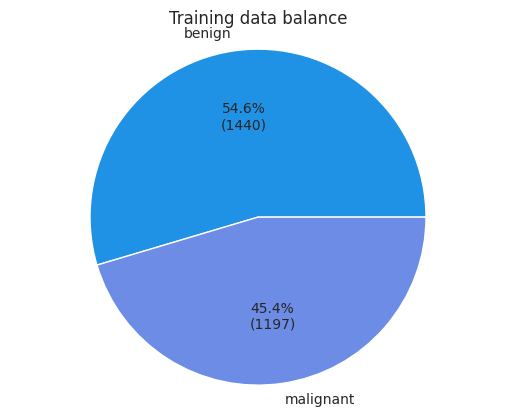

In [ ]:
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [ ]:
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)


In [ ]:
# crobed image size
batch_size = 8
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Confusion Matrix
def plot_confusion_matrix(model, test_gen):
    # Get Predictions
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# freeze the layers in conv5_block3
for layer in base_model.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# fine-tune ResNet50 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)   # Dropout layer to prevent overfitting
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# for layer in ResNet50_model.layers:
#     print(layer.name, layer.trainable)

In [ ]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

ResNet50_model.summary()

In [ ]:
epochs = 20   # number of all epochs in training

ResNet50_history = ResNet50_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
330/330 [==============================] - 706s 2s/step - loss: 0.5106 - accuracy: 0.7562 - val_loss: 0.9963 - val_accuracy: 0.4212
Epoch 2/20
330/330 [==============================] - 18s 54ms/step - loss: 0.4306 - accuracy: 0.8032 - val_loss: 0.5657 - val_accuracy: 0.6970
Epoch 3/20
330/330 [==============================] - 22s 65ms/step - loss: 0.4140 - accuracy: 0.8070 - val_loss: 0.5440 - val_accuracy: 0.7545
Epoch 4/20
330/330 [==============================] - 22s 67ms/step - loss: 0.4041 - accuracy: 0.8138 - val_loss: 0.5795 - val_accuracy: 0.7212
Epoch 5/20
330/330 [==============================] - 20s 60ms/step - loss: 0.3753 - accuracy: 0.8286 - val_loss: 0.4686 - val_accuracy: 0.7606
Epoch 6/20
330/330 [==============================] - 17s 52ms/step - loss: 0.3592 - accuracy: 0.8362 - val_loss: 0.5010 - val_accuracy: 0.7576
Epoch 7/20
330/330 [==============================] - 17s 51ms/step - loss: 0.3529 - accuracy: 0.8407 - val_loss: 0.3999 - val_accuracy: 

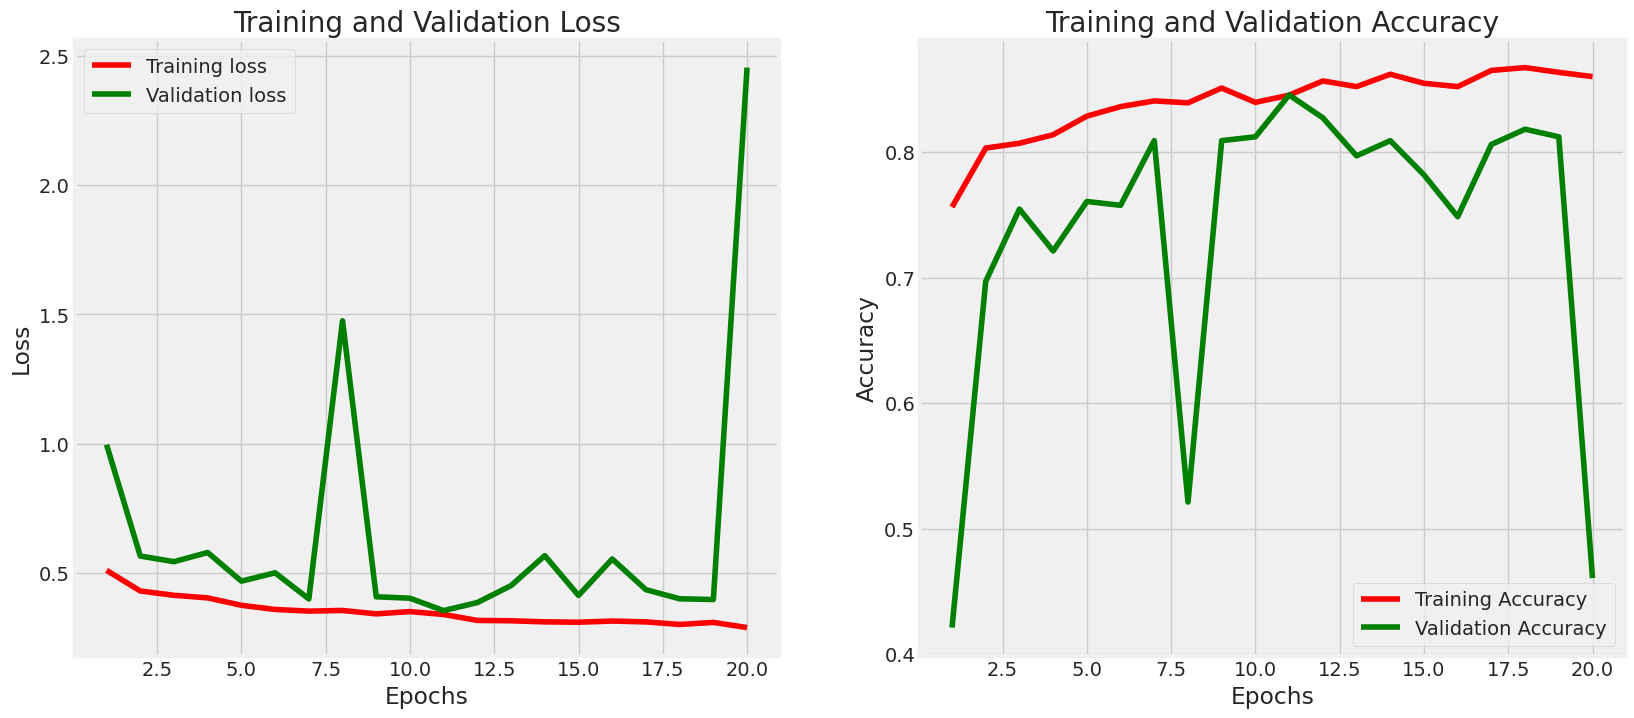

In [ ]:
model_performance(ResNet50_history, epochs)

In [ ]:
model_evaluation(ResNet50_model)

42/42 [==============================] - 74s 2s/step - loss: 2.2300 - accuracy: 0.5061
Train Loss:  2.1918468475341797
Train Accuracy:  0.4816078841686249
--------------------
Validation Loss:  2.453806161880493
Validation Accuracy:  0.46060606837272644
--------------------
Test Loss:  2.2299997806549072
Test Accuracy:  0.5060606002807617


42/42 [==============================] - 3s 39ms/step


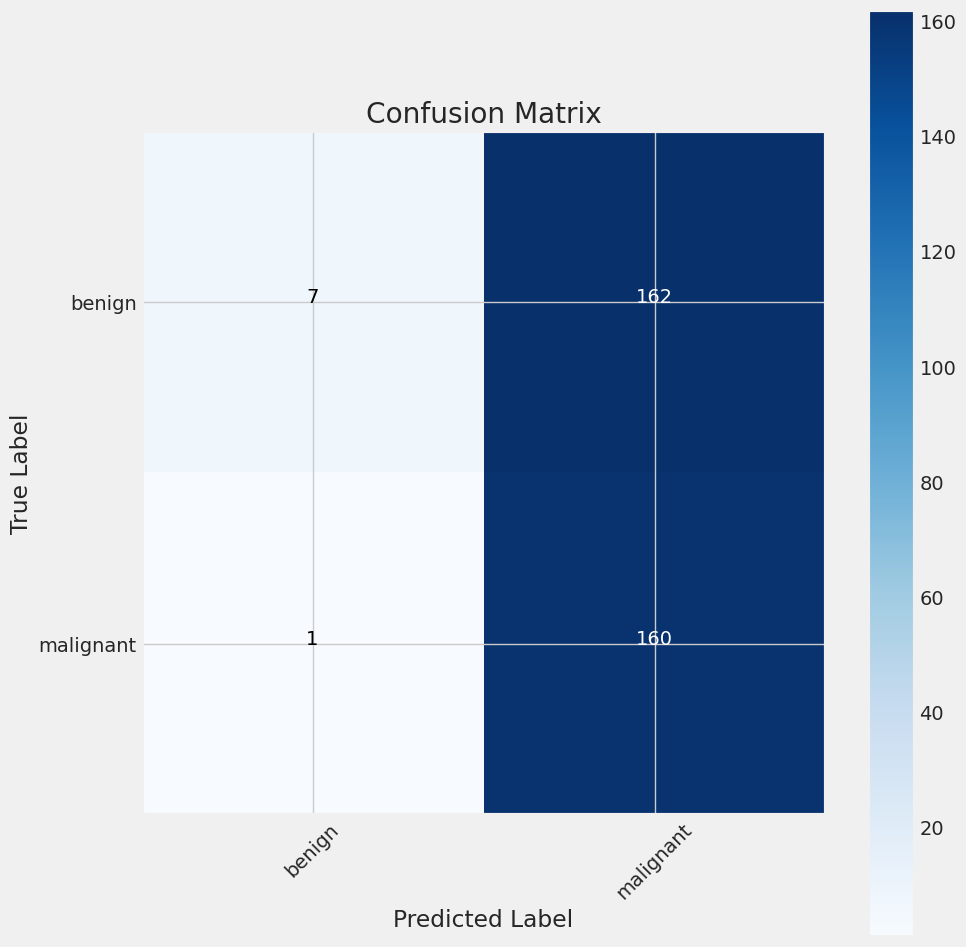

In [ ]:
plot_confusion_matrix(ResNet50_model, test_gen)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

# freeze four convolution blocks
for layer in base_model.layers[:15]:
    layer.trainable = False


# fine-tune VGG16 (Adding some custom layers on top)
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# # Check the trainable status of the layers
# for layer in VGG16_model.layers:
#     print(layer.name, layer.trainable)

In [ ]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
epochs = 15   # number of all epochs in training

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
330/330 [==============================] - 31s 79ms/step - loss: 0.4336 - accuracy: 0.8047 - val_loss: 0.3967 - val_accuracy: 0.8061
Epoch 2/15
330/330 [==============================] - 24s 71ms/step - loss: 0.3272 - accuracy: 0.8529 - val_loss: 0.3480 - val_accuracy: 0.8121
Epoch 3/15
330/330 [==============================] - 23s 69ms/step - loss: 0.2844 - accuracy: 0.8714 - val_loss: 0.3212 - val_accuracy: 0.8697
Epoch 4/15
330/330 [==============================] - 22s 67ms/step - loss: 0.2617 - accuracy: 0.8790 - val_loss: 0.3427 - val_accuracy: 0.8333
Epoch 5/15
330/330 [==============================] - 22s 68ms/step - loss: 0.2237 - accuracy: 0.9056 - val_loss: 0.3196 - val_accuracy: 0.8455
Epoch 6/15
330/330 [==============================] - 22s 67ms/step - loss: 0.1772 - accuracy: 0.9283 - val_loss: 0.3775 - val_accuracy: 0.8424
Epoch 7/15
330/330 [==============================] - 22s 65ms/step - loss: 0.1384 - accuracy: 0.9458 - val_loss: 0.3256 - val_accuracy:

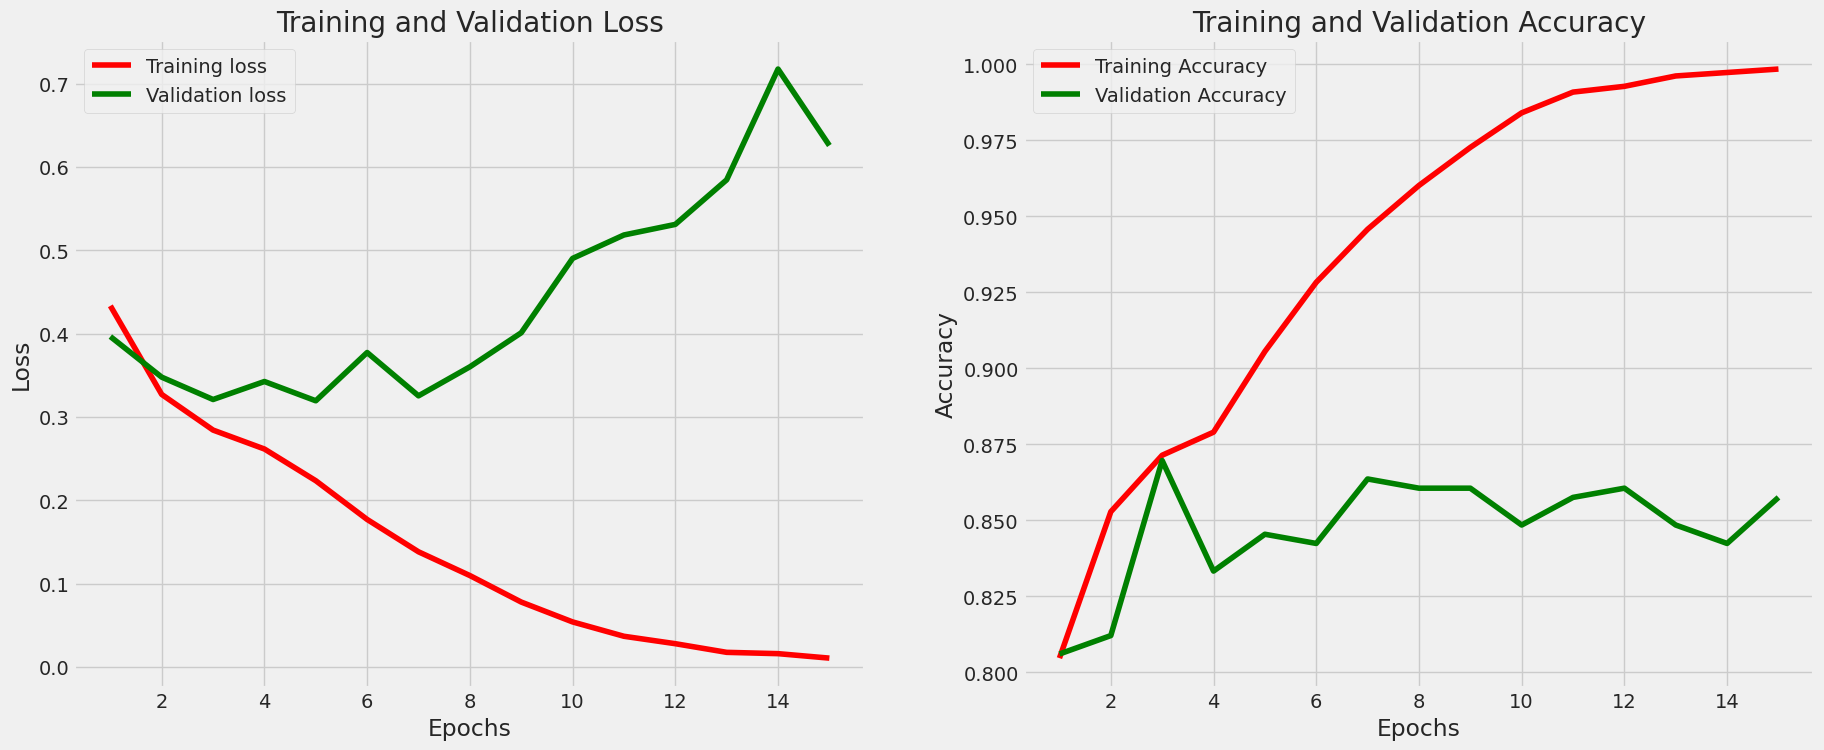

In [ ]:
model_performance(VGG16_history, epochs)

In [ ]:
model_evaluation(VGG16_model)

330/330 [==============================] - 16s 48ms/step - loss: 0.0046 - accuracy: 0.9996


42/42 [==============================] - 2s 47ms/step


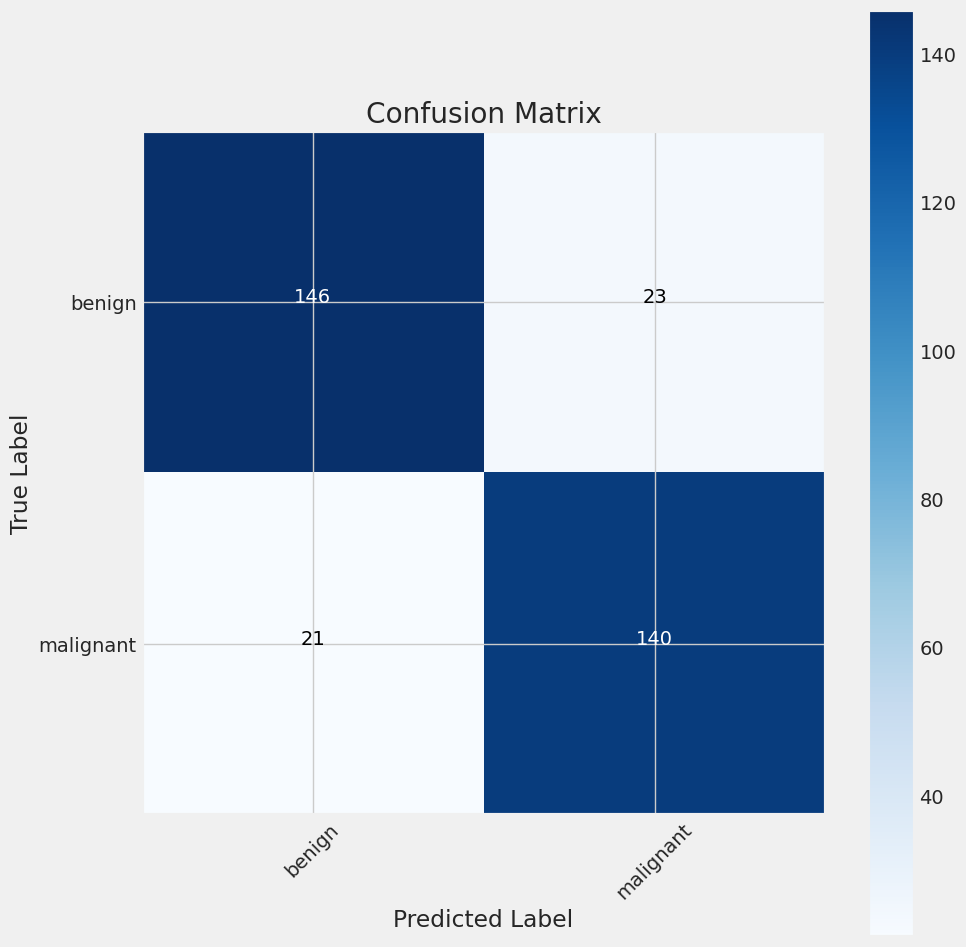

In [ ]:
plot_confusion_matrix(VGG16_model, test_gen)